In [1]:
import os
import pickle
import numpy as np
from torch.utils.data import Subset, ConcatDataset
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torchvision import datasets

In [2]:
# Check if running on Colab
try:
  import google.colab
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  from google.colab import drive
  # Connect to Google drive where the training data is located
  drive.mount("/content/gdrive")
  work_dir = "/content/gdrive/My Drive/Colab Notebooks/DL-Project-2024-Experiments/SUBMISSION"
  os.chdir(work_dir)
  print(f"Connected to Google drive, setting working directory to '{work_dir}'")

Mounted at /content/gdrive
Connected to Google drive, setting working directory to '/content/gdrive/My Drive/Colab Notebooks/DL-Project-2024-Experiments/SUBMISSION'


In [3]:
# Create plot folder if it does not exist yet
plot_folder_name = 'buffer_overlaps_results'
if not os.path.exists(plot_folder_name):
    os.makedirs(plot_folder_name)

In [4]:
# Load CIFAR 10
print("Loading CIFAR10 data...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
print(f"Loaded CIFAR10 data: training={len(trainset)} items, testing={len(testset)} items.")

Loading CIFAR10 data...
Files already downloaded and verified
Files already downloaded and verified
Loaded CIFAR10 data: training=50000 items, testing=10000 items.


In [5]:
def split_dataset_to_labels(dataset, subset_labels):
  return Subset(dataset, [i for i,label in enumerate(dataset.targets) if label in subset_labels])

subset_A_labels=[0,1,2,3,4]
subset_B_labels=[5,6,7,8,9]

# split the CIFAR10 data into two subsets according to their labels
trainset_A=split_dataset_to_labels(trainset, subset_A_labels)
trainset_B=split_dataset_to_labels(trainset, subset_B_labels)

testset_A=split_dataset_to_labels(testset, subset_A_labels)
testset_B=split_dataset_to_labels(testset, subset_B_labels)

In [6]:
# look for the first available baseline pickle file
baseline_file_name_start="task_accuracies_data_e2e_ep_50_ex_"
baseline_file_name_end="_b_0.0_gl_0.0_mpe_0.0_gll_0.0_glh_0.0_mpeh_False.pkl"
folder="raw_result_data"
learning_speeds_ranking=None
sensitivities=None
for filename in os.listdir(folder):
  if filename.startswith(baseline_file_name_start) and filename.endswith(baseline_file_name_end):
    file_path = os.path.join(folder, filename)
    loaded_results = None
    with open(file_path, 'rb') as f:
      loaded_results = pickle.load(f)
      learning_speeds=loaded_results["learning_speeds"]
      sensitivities=loaded_results["sensitivities"]

In [7]:
def get_random_buffer(dataset, n_samples):
  rng=np.random.default_rng()
  buffer_set=Subset(dataset, rng.choice(len(dataset),n_samples, replace=False))
  return buffer_set

def get_goldilocks_buffer(dataset, n_samples, learning_speeds, remove_lowest_pct=0.0, remove_highest_pct=0.0):
  learning_speeds_ranking=np.argsort(learning_speeds)
  rng=np.random.default_rng()
  buffer_set=Subset(dataset, rng.choice(learning_speeds_ranking[int(len(learning_speeds)*remove_lowest_pct):int(len(learning_speeds)*(1.0-remove_highest_pct))],n_samples, replace=False))
  return buffer_set

def get_sensitivity_buffer(dataset, n_samples, sensitivities, highest):
  sensitivities_ranking=np.argsort(sensitivities)
  if highest:
    sensitivities_ranking=sensitivities_ranking[::-1]
  buffer_set=Subset(dataset, sensitivities_ranking[0:n_samples])
  return buffer_set

def get_mixed_buffer(dataset, size_pct, goldilocks_rate=0.0, mpe_rate=0.0, learning_speeds=None, sensitivities=None, goldilocks_remove_lowest_pct=0.0, goldilocks_remove_highest_pct=0.0, mpe_highest=False):
  n_samples_total=int(len(dataset)*size_pct)
  n_samples_goldilocks=0
  n_samples_mpe=0
  n_samples_random=0

  # This logic is to avoid being off by 1 sample due to rounding
  if goldilocks_rate==0.0:
    n_samples_mpe=int(n_samples_total*mpe_rate)
    n_samples_random=n_samples_total-n_samples_mpe
  elif mpe_rate==0:
    n_samples_goldilocks=int(n_samples_total*goldilocks_rate)
    n_samples_random=n_samples_total-n_samples_goldilocks
  elif goldilocks_rate+mpe_rate==1.0:
    n_samples_goldilocks=int(n_samples_total*goldilocks_rate)
    n_samples_mpe=n_samples_total-n_samples_goldilocks
  else:
    n_samples_goldilocks=int(n_samples_total*goldilocks_rate)
    n_samples_mpe=int(n_samples_total*mpe_rate)
    n_samples_random=n_samples_total-n_samples_goldilocks-n_samples_mpe

  mix=[]

  if n_samples_goldilocks>0:
    b = get_goldilocks_buffer(dataset, n_samples_goldilocks, learning_speeds, remove_lowest_pct=goldilocks_remove_lowest_pct, remove_highest_pct=goldilocks_remove_highest_pct)
    mix.append(b)
  if n_samples_mpe>0:
    b = get_sensitivity_buffer(dataset, n_samples_mpe, sensitivities, mpe_highest)
    mix.append(b)
  if n_samples_random>0:
    b = get_random_buffer(dataset, n_samples_random)
    mix.append(b)

  buffer_set=Subset(dataset, [])
  if len(mix)>0:
    buffer_set = ConcatDataset(mix)

  return buffer_set

def plot_overlaps(buffer_sizes, overlap_ratios, file_name_info):

  reference=buffer_sizes
  plt.plot(buffer_sizes, overlap_ratios, label="Overlap", color="b")
  plt.plot(buffer_sizes, reference, label="Uncorrelated", color="r")
  plt.xlabel("Buffer size")
  plt.ylabel("Buffer overlap")
  plt.legend()
  #plt.show()
  plt.savefig(f'{plot_folder_name}/buffer_overlaps_{file_name_info}.png')

def perform_experiment_loop(goldilocks_remove_lowest_pct, goldilocks_remove_highest_pct, mpe_highest, max_pct):

  inc=0.01
  buffer_sizes=np.arange(2*inc, 2*max_pct+inc, 2*inc)
  overlaps=[]
  for buffer_size in buffer_sizes:
    buffer_set = get_mixed_buffer(trainset_A, buffer_size, 0.50, 0.50, learning_speeds, sensitivities, goldilocks_remove_lowest_pct, goldilocks_remove_highest_pct, mpe_highest)
    unique_indices=set()
    unique_indices.update(buffer_set.datasets[0].indices)
    unique_indices.update(buffer_set.datasets[1].indices)
    n_buffer=int(buffer_size*len(trainset_A))
    n_non_unique=int(2*(n_buffer-len(unique_indices)))
    overlap=n_non_unique/n_buffer
    overlaps.append(overlap)

  file_name_info=f"{int(100*goldilocks_remove_lowest_pct)}_{int(100*goldilocks_remove_highest_pct)}_{mpe_highest}_{int(100*max_pct)}"
  plot_overlaps(buffer_sizes/2, overlaps, file_name_info)

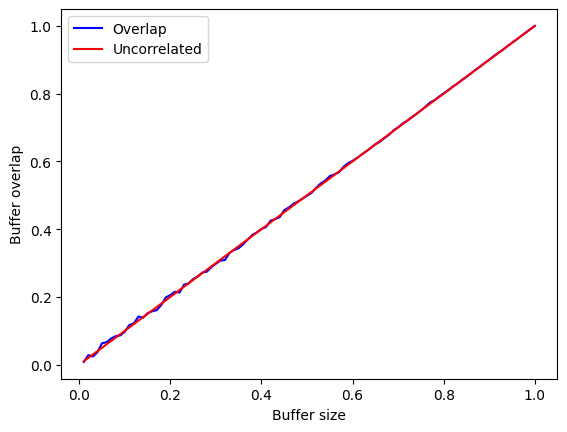

In [8]:
perform_experiment_loop(goldilocks_remove_lowest_pct=0.00, goldilocks_remove_highest_pct=0.00, mpe_highest=True, max_pct=1.00)

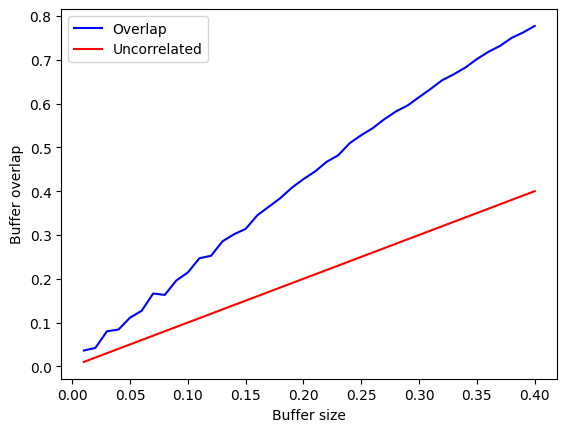

In [9]:
perform_experiment_loop(goldilocks_remove_lowest_pct=0.00, goldilocks_remove_highest_pct=0.60, mpe_highest=True, max_pct=0.40)

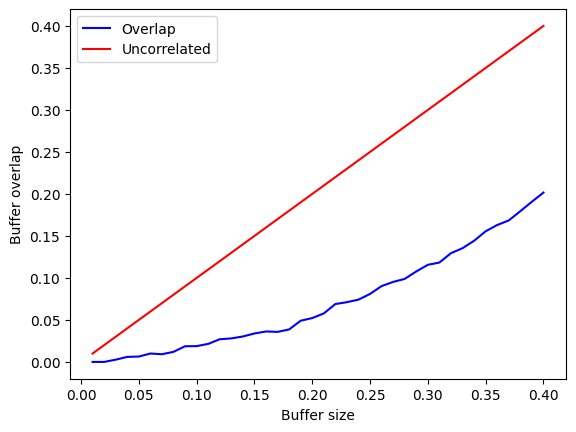

In [10]:
perform_experiment_loop(goldilocks_remove_lowest_pct=0.15, goldilocks_remove_highest_pct=0.45, mpe_highest=False, max_pct=0.40)

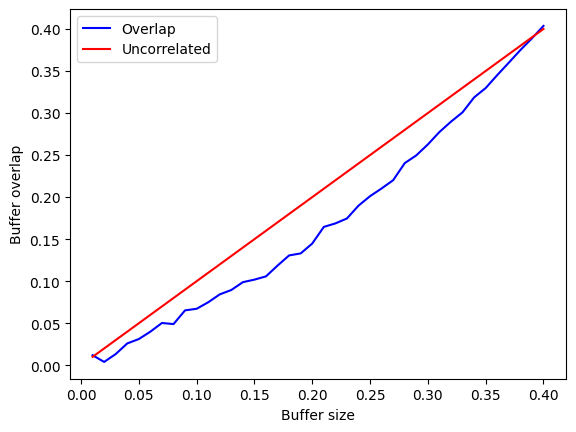

In [11]:
perform_experiment_loop(goldilocks_remove_lowest_pct=0.30, goldilocks_remove_highest_pct=0.30, mpe_highest=False, max_pct=0.40)

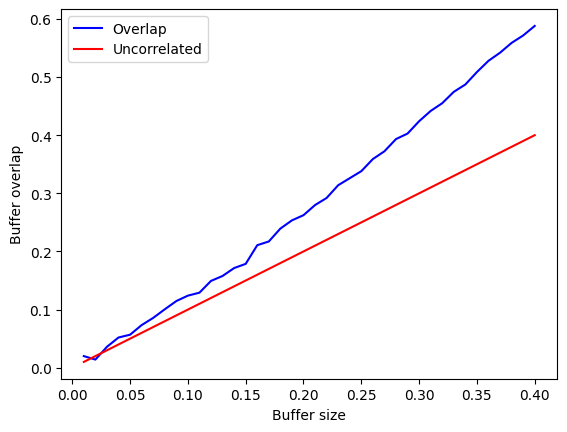

In [12]:
perform_experiment_loop(goldilocks_remove_lowest_pct=0.45, goldilocks_remove_highest_pct=0.15, mpe_highest=False, max_pct=0.40)

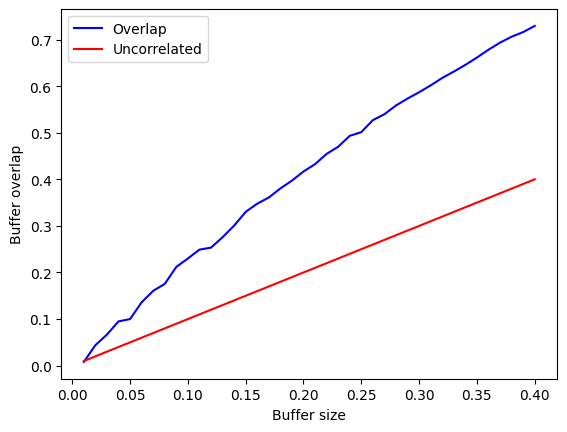

In [13]:
perform_experiment_loop(goldilocks_remove_lowest_pct=0.60, goldilocks_remove_highest_pct=0.00, mpe_highest=False, max_pct=0.40)

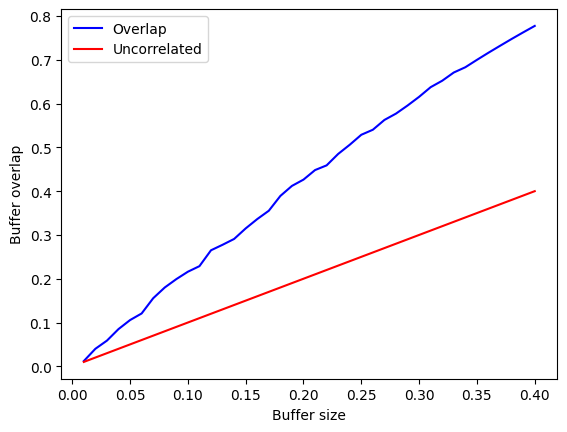

In [14]:
perform_experiment_loop(goldilocks_remove_lowest_pct=0.00, goldilocks_remove_highest_pct=0.60, mpe_highest=True, max_pct=0.40)

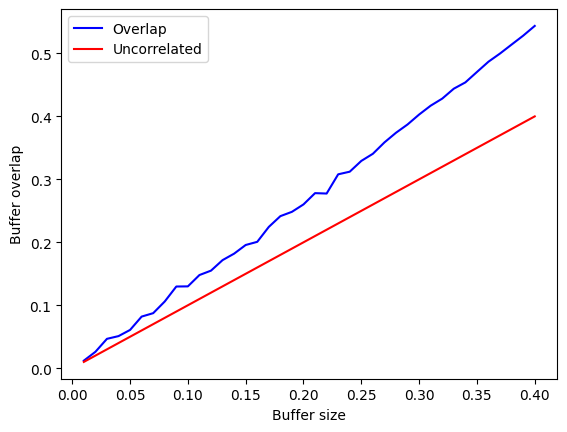

In [15]:
perform_experiment_loop(goldilocks_remove_lowest_pct=0.15, goldilocks_remove_highest_pct=0.45, mpe_highest=True, max_pct=0.40)

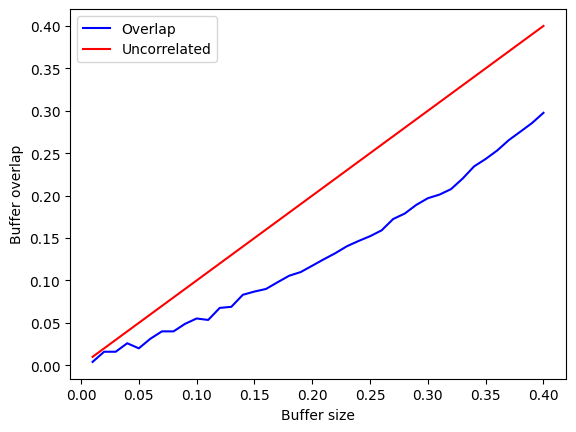

In [16]:
perform_experiment_loop(goldilocks_remove_lowest_pct=0.30, goldilocks_remove_highest_pct=0.30, mpe_highest=True, max_pct=0.40)

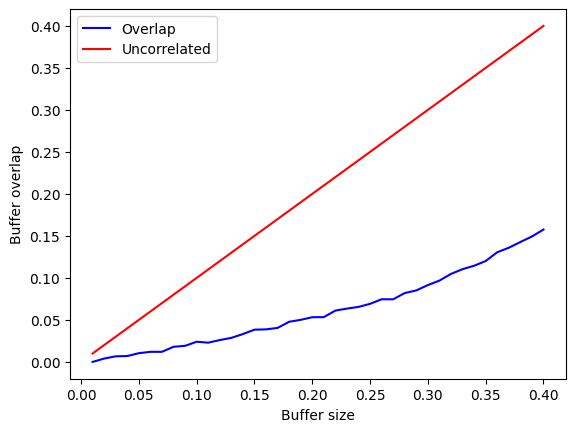

In [17]:
perform_experiment_loop(goldilocks_remove_lowest_pct=0.45, goldilocks_remove_highest_pct=0.15, mpe_highest=True, max_pct=0.40)

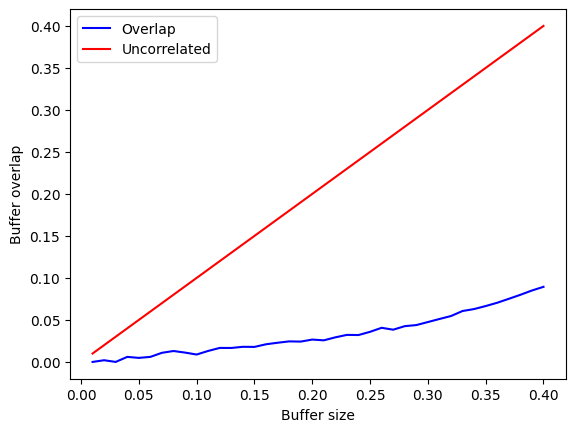

In [18]:
perform_experiment_loop(goldilocks_remove_lowest_pct=0.60, goldilocks_remove_highest_pct=0.00, mpe_highest=True, max_pct=0.40)